https://arxiv.org/pdf/1606.01933.pdf

In [24]:
import pickle
import random

#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import h5py
#import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm
#% matplotlib inline

random.seed(42)

In [2]:
import keras
import keras.backend as K
from keras.layers import InputSpec, Input, Dense, Flatten, Permute
from keras.layers import Lambda, Masking, Activation, Dropout, Embedding, TimeDistributed
from keras.layers import Bidirectional, GRU, LSTM
from keras.layers.advanced_activations import ELU
from keras.layers.merge import Add, Dot, add, concatenate, dot
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.engine.topology import Layer
from keras.models import Sequential, Model, model_from_json
from keras.regularizers import l2
from keras.optimizers import Adam

Using TensorFlow backend.


# Custom Spacy pipline

In [3]:
def get_embeddings(vocab, nr_unk=100):
    nr_vector = max(lex.rank for lex in vocab) + 1
    vectors = np.zeros((nr_vector+nr_unk+2, vocab.vectors_length), dtype='float32')
    
    for lex in vocab:
        if lex.has_vector:
            vectors[lex.rank+1] = lex.vector
            #vectors[lex.rank+1] = lex.vector / lex.vector_norm
    return vectors

In [4]:
def get_word_ids(docs, rnn_encode=False, tree_truncate=False, max_length=100, nr_unk=100):
    Xs = np.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        if tree_truncate:
            if isinstance(doc, Span):
                queue = [doc.root]
            else:
                queue = [sent.root for sent in doc.sents]
        else:
            queue = list(doc)
        words = []
        while len(words) <= max_length and queue:
            word = queue.pop(0)
            if rnn_encode or (not word.is_punct and not word.is_space):
                words.append(word)
            if tree_truncate:
                queue.extend(list(word.lefts))
                queue.extend(list(word.rights))
        words.sort()
        for j, token in enumerate(words):
            if token.has_vector:
                Xs[i, j] = token.rank+1
            else:
                Xs[i, j] = (token.shape % (nr_unk-1))+2
            j += 1
            if j >= max_length:
                break
        else:
            Xs[i, len(words)] = 1
    return Xs

In [5]:
class QuoraSimilarity(object):
    @classmethod
    def load(cls, path, nlp, get_features=None, max_length=100):
        if get_features is None:
            get_features = get_word_ids
        with (path / 'config.json').open() as file_:
            model = model_from_json(file_.read())
        with (path / 'model').open('rb') as file_:
            weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + weights)
        return cls(model, get_features=get_features, max_length=max_length)

    def __init__(self, model, get_features=None, max_length=100):
        self.model = model
        self.get_features = get_features
        self.max_length = max_length

    def __call__(self, doc):
        doc.user_hooks['similarity'] = self.predict
        doc.user_span_hooks['similarity'] = self.predict

    def predict(self, doc1, doc2):
        x1 = self.get_features([doc1], max_length=self.max_length, tree_truncate=False)
        x2 = self.get_features([doc2], max_length=self.max_length, tree_truncate=False)
        scores = self.model.predict([x1, x2])
        return scores[0]

In [6]:
def create_quora_similarity_pipeline(nlp, max_length=100):
    return [
        nlp.tagger,
        nlp.entity,
        nlp.parser,
        QuoraSimilarity.load('path here', nlp, max_length)
    ]

# Keras Model

In [7]:
def build_model(vectors, shape, settings):
    max_length, nr_hidden, nr_class = shape
    
    # Inputs
    ids1 = Input(shape=(max_length,), dtype='int32', name='words1')
    ids2 = Input(shape=(max_length,), dtype='int32', name='words2')
    
    # Embed
    embed = Embedding(vectors.shape[0],
                      vectors.shape[1],
                      input_length=max_length,
                      weights=[vectors],
                      name='embed',
                      trainable=False)
    project = TimeDistributed(Dense(nr_hidden,
                                    activation=None,
                                    use_bias=False,
                                    name='project'))
    
    sent1 = project(embed(ids1))
    sent2 = project(embed(ids2))
    sent1 = Dropout(settings['dropout'])(sent1)
    sent2 = Dropout(settings['dropout'])(sent2)
    
    # Attend
    F_p, F_h = sent1, sent2
    for i in range(2):
        scoreF = TimeDistributed(Dense(nr_hidden,
                                       activation='relu', 
                                       kernel_initializer='he_normal'))
        F_p = Dropout(settings['dropout'])(scoreF(F_p))
        F_h = Dropout(settings['dropout'])(scoreF(F_h))
    Eph = Dot(axes=(2, 2))([F_p, F_h])
    
    # Normalize and align
    Ep = Activation('softmax', name='Ep')(Eph)
    Eh = Permute((2, 1))(Eph)
    Eh = Activation('softmax', name='Eh')(Eh)
    PremAlign = Dot((2, 1))([Ep, sent2])
    HypoAlign = Dot((2, 1))([Eh, sent1])
    
    # Concat and compare
    PremAlign = concatenate([sent1, PremAlign])
    HypoAlign = concatenate([sent2, HypoAlign])
    for i in range(2):
        scoreG = TimeDistributed(Dense(nr_hidden,
                                       activation='relu', 
                                       kernel_initializer='he_normal'))
        PremAlign = Dropout(settings['dropout'])(scoreG(PremAlign))
        HypoAlign = Dropout(settings['dropout'])(scoreG(HypoAlign))
        
    avged_p = GlobalAveragePooling1D()(PremAlign)
    maxed_p = GlobalMaxPooling1D()(PremAlign)
    merged_p = add([avged_p, maxed_p])
    result_p = BatchNormalization()(merged_p)
    
    avged_h = GlobalAveragePooling1D()(HypoAlign)
    maxed_h = GlobalMaxPooling1D()(HypoAlign)
    merged_h = add([avged_h, maxed_h])
    result_h = BatchNormalization()(merged_h)
        
    # Aggregate
    features = concatenate([result_p, result_h])
    for i in range(2):
        scoreH = Dense(nr_hidden,
                       activation='relu', 
                       kernel_initializer='he_normal')
        features = Dropout(settings['dropout'])(scoreH(features))
        
    scores = Dense(nr_class,
                   activation='sigmoid', 
                   kernel_initializer='zero')(features)
    
    # Model object
    model = Model(inputs=[ids1, ids2], outputs=scores)

    model.compile(
        optimizer=Adam(lr=settings['lr']),
        loss='binary_crossentropy',
        #loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Load data

In [8]:
train_df = pd.read_csv('../data/input/train.csv', index_col='id')

train_df['question1'].fillna('', inplace=True)
train_df['question2'].fillna('', inplace=True)

# filter out question shorter than 10 characters
train_df['q1_len'] = train_df['question1'].str.len()
train_df['q2_len'] = train_df['question2'].str.len()

train_df = train_df.loc[lambda df: (df['q1_len'] > 10) & (df['q2_len'] > 10)]

# subset data
train_df = train_df.loc[0:199999]

train_df['is_duplicate'].value_counts()

0    125461
1     74472
Name: is_duplicate, dtype: int64

# Train Model

In [9]:
nlp = spacy.load('en')

shape = (30, 200, 1)
settings = {
    'lr': 0.0001,
    'dropout': 0.2
}

print('Build model')
model = build_model(get_embeddings(nlp.vocab), shape, settings)

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(train_df['question1'].values, 
                                                                      train_df['question2'].values,
                                                                      train_df['is_duplicate'].values, 
                                                                      test_size=0.2, random_state=42, 
                                                                      stratify=train_df['is_duplicate'].values)

print('Encode training and validation datasets')
train_X1 = get_word_ids(list(nlp.pipe(X1_train.tolist(), n_threads=20, batch_size=10000)),
                        max_length=30,
                        rnn_encode=False,
                        tree_truncate=False)

train_X2 = get_word_ids(list(nlp.pipe(X2_train.tolist(), n_threads=20, batch_size=10000)),
                        max_length=30,
                        rnn_encode=False,
                        tree_truncate=False)

val_X1 = get_word_ids(list(nlp.pipe(X1_val.tolist(), n_threads=20, batch_size=10000)),
                        max_length=30,
                        rnn_encode=False,
                        tree_truncate=False)

val_X2 = get_word_ids(list(nlp.pipe(X2_val.tolist(), n_threads=20, batch_size=10000)),
                        max_length=30,
                        rnn_encode=False,
                        tree_truncate=False)

Build model
Get Embeddings


In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
words1 (InputLayer)              (None, 30)            0                                            
____________________________________________________________________________________________________
words2 (InputLayer)              (None, 30)            0                                            
____________________________________________________________________________________________________
embed (Embedding)                (None, 30, 300)       222698100   words1[0][0]                     
                                                                   words2[0][0]                     
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 30, 200)       60000       embed[0][0]             

____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 200)           800         add_2[0][0]                      
____________________________________________________________________________________________________
concatenate_3 (Concatenate)      (None, 400)           0           batch_normalization_1[0][0]      
                                                                   batch_normalization_2[0][0]      
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 200)           80200       concatenate_3[0][0]              
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 200)           0           dense_5[0][0]                    
___________________________________________________________________________________________

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1),
    keras.callbacks.CSVLogger(filename='..\logs\checkpoints\model_log.csv'),
    keras.callbacks.ModelCheckpoint('..\models\checkpoints\weights.{epoch:03d}-{val_loss:0.4f}.hdf5',
                                    save_best_only=True,
                                    save_weights_only=True,
                                    period=10),
    keras.callbacks.TensorBoard(log_dir='..\logs\\tensorboard',
                                histogram_freq=1)
]

# Train model
model.fit([train_X1, train_X2],
          y_train,
          validation_data=([val_X1, val_X2], y_val),
          epochs=100,
          batch_size=64, 
          verbose=2,
          callbacks=callbacks)

Train on 159946 samples, validate on 39987 samples
INFO:tensorflow:Summary name embed/embeddings:0 is illegal; using embed/embeddings_0 instead.
INFO:tensorflow:Summary name time_distributed_1/kernel:0 is illegal; using time_distributed_1/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_2/kernel:0 is illegal; using time_distributed_2/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_2/bias:0 is illegal; using time_distributed_2/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_3/kernel:0 is illegal; using time_distributed_3/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_3/bias:0 is illegal; using time_distributed_3/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_4/kernel:0 is illegal; using time_distributed_4/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_4/bias:0 is illegal; using time_distributed_4/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_5/kernel:0 is illegal; using time_dis

## Save model

In [12]:
model.save('../models/model_decomposable_attention.hdf5')

In [11]:
model = keras.models.load_model('../models/model_decomposable_attention.hdf5')

# Predicitons

In [34]:
train_pred = model.predict([train_X1, train_X2])
train_pred = [1 if i > 0.5 else 0 for i in train_pred.ravel().tolist()]
confusion_matrix(y_train.tolist(), train_pred)

array([[71475, 28894],
       [ 5529, 54048]])

In [33]:
val_pred = model.predict([val_X1, val_X2])
val_pred = [1 if i > 0.5 else 0 for i in val_pred.ravel().tolist()]
confusion_matrix(y_val.tolist(), val_pred)

array([[17265,  7827],
       [ 1783, 13112]])

# Custom Tests

In [9]:
nlp = spacy.load('en')

In [11]:
model = keras.models.load_model('../models/model_decomposable_attention.hdf5')

In [10]:
attention_layer_model = Model(inputs=model.input,
                              outputs=[model.get_layer('Ep').get_output_at(0),
                                       model.get_layer('Eh').get_output_at(0)])

In [11]:
def test_entailment(sentence1, sentence2):
    sent1 = nlp(sentence1)
    sentence1 = get_word_ids(list([sent1]), 
                             max_length=30,
                             rnn_encode=False,
                             tree_truncate=False)
    
    sent2 = nlp(sentence2)
    sentence2 = get_word_ids(list([sent2]), 
                             max_length=30,
                             rnn_encode=False,
                             tree_truncate=False)

    prediction = model.predict([sentence1, sentence2])
    attention_output = attention_layer_model.predict([sentence1, sentence2])
    
    return prediction[0][0], attention_output, [sent1, sent2]

In [15]:
#sentence1 = 'What are some ways to find the voltage across a resistor?'
#sentence2 = 'How can I get voltage drop across a resistor? And how can I calculate it?'
#sentence1 = 'How can I play football?'
#sentence2 = 'How can I cook duck?'
#sentence1 = 'How can I learn to play soccer better?'
#sentence2 = 'What is the optimal way to improve at soccer?'
sentence1 = 'What day of the week comes after Thursday?'
sentence2 = 'What day of the week comes before Sunday?'

prediction, attention_output, [sent1, sent2] = test_entailment(sentence1, sentence2)
print(prediction)

0.835688


In [16]:
Ep, Eh = attention_output[0][0], attention_output[1][0] # [P,H] [H,P]
Ep = Ep[:len(sent1),:len(sent2)] # [P,H]
Eh = Eh[:len(sent2),:len(sent1)] # [H,P]

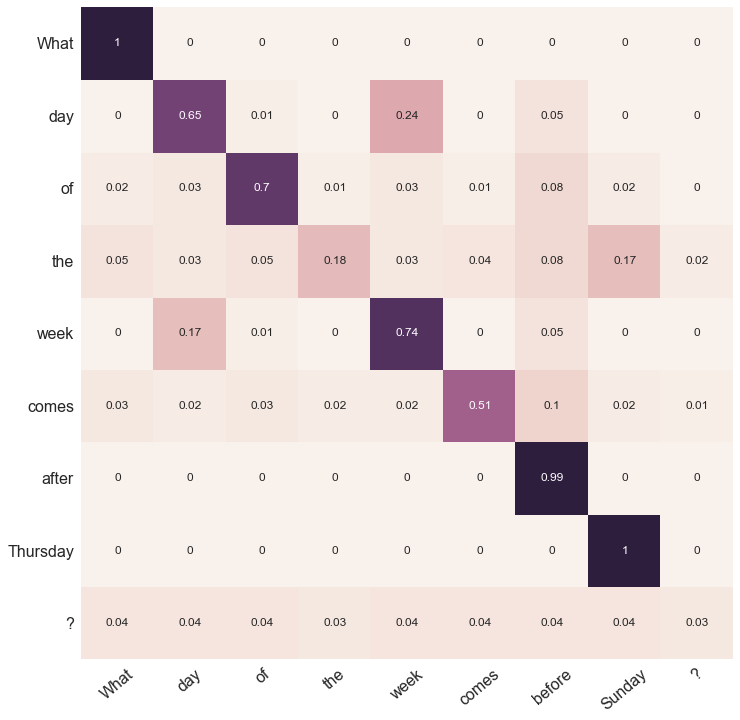

In [17]:
plt.clf()
df = pd.DataFrame(np.round(Ep, 2),columns=sent2,index=sent1)

ax = sns.heatmap(df, vmax=.85, square=True, cbar=False, annot=True)
plt.xticks(rotation=40, fontsize=16), plt.yticks(rotation=360, fontsize=16)
fig = ax.get_figure()
fig.set_size_inches((12, 12))
fig

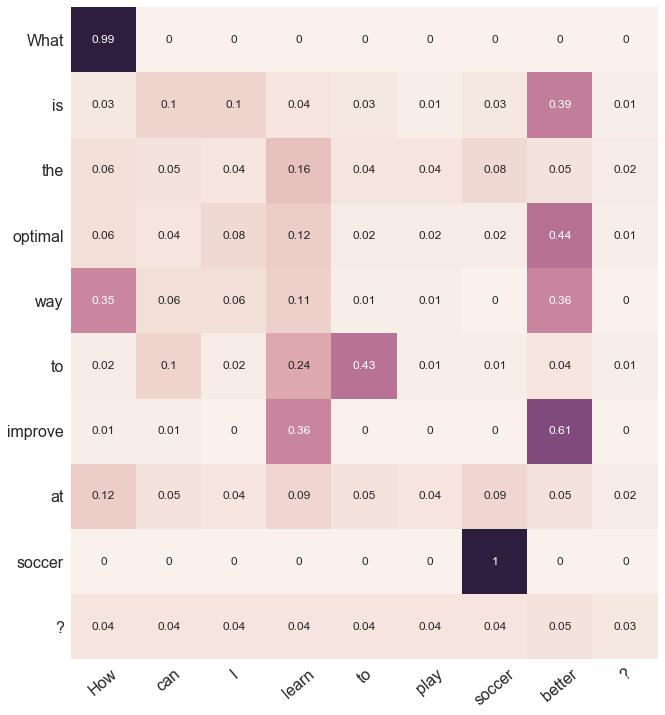

In [70]:
plt.clf()
df = pd.DataFrame(np.round(Eh, 2),columns=sent1,index=sent2)

ax = sns.heatmap(df, vmax=.85, square=True, cbar=False, annot=True)
plt.xticks(rotation=40, fontsize=16), plt.yticks(rotation=360, fontsize=16)
fig = ax.get_figure()
fig.set_size_inches((12, 12))
fig